# At the end the GAN model is a binary classification problem: The Discriminator part of the model has to distinguish whether the data is fake or real. 

In [24]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import math # for generating real data (points on a circle in this case)

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for data visualizations
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
import plotly
import plotly.express as px # for data visualizations
print('plotly: %s' % plotly.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Tensorflow/Keras: 2.7.0
numpy: 1.22.4
pandas: 1.3.4
matplotlib: 3.4.3
graphviz: 0.20.1
plotly: 4.14.3


In [25]:
# A function to get coordinates of points on circle's circumference
def PointsInCircum(r,n):
    return [(math.cos(2*math.pi/n*x)*r,math.sin(2*math.pi/n*x)*r) for x in range(0,n+1)]

In [26]:
# Save coordinates of a set of real points making up a circle with radius=2
circle=np.array(PointsInCircum(r=2,n=1000))

In [27]:
circle

array([[ 2.00000000e+00,  0.00000000e+00],
       [ 1.99996052e+00,  1.25662879e-02],
       [ 1.99984209e+00,  2.51320798e-02],
       ...,
       [ 1.99984209e+00, -2.51320798e-02],
       [ 1.99996052e+00, -1.25662879e-02],
       [ 2.00000000e+00, -4.89858720e-16]])

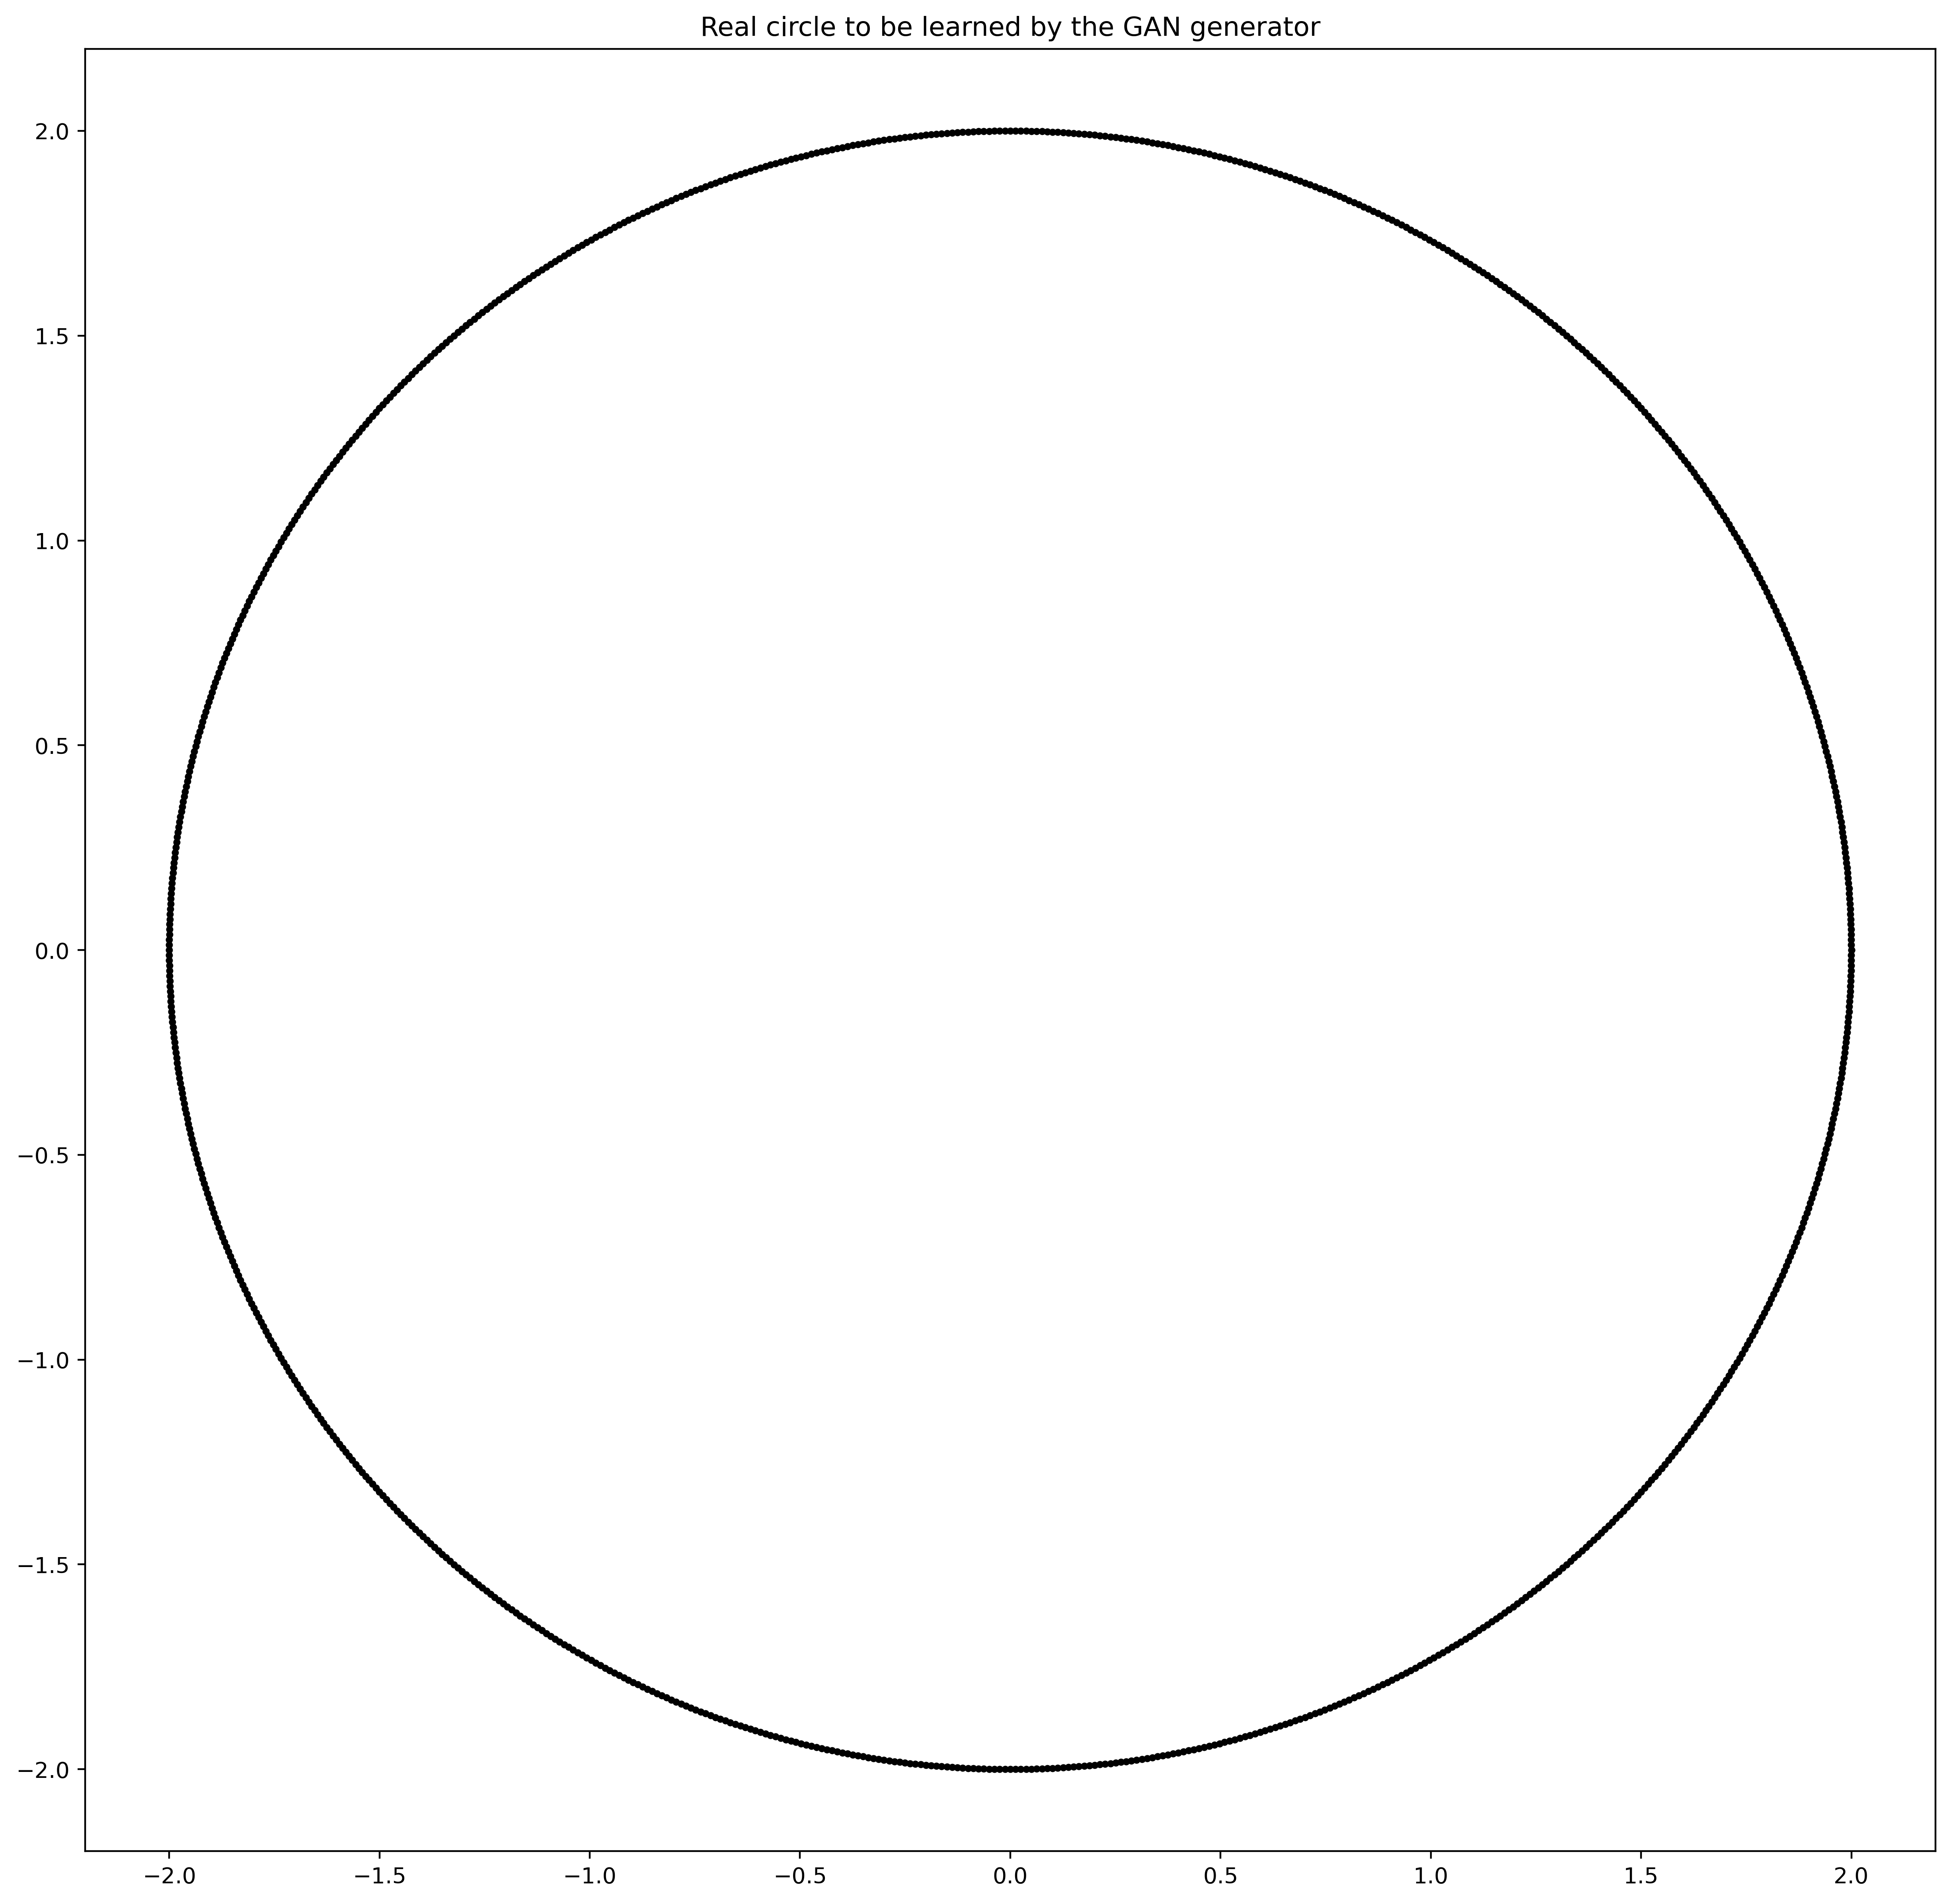

In [28]:
# Draw a chart
plt.figure(figsize=(15,15), dpi=400)
plt.title(label='Real circle to be learned by the GAN generator', loc='center')
plt.scatter(circle[:,0], circle[:,1], s=5, color='black')
plt.show()

# The above code generates 1,000 points and draws a graph displaying our circle.

In [29]:
# Define Generator model
def generator(latent_dim, n_outputs=2):
    model = Sequential(name="Generator") # Model
    
    # Add Layers
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim, name='Generator-Hidden-Layer-1')) # Hidden Layer
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Generator-Hidden-Layer-2')) # Hidden Layer
    model.add(Dense(n_outputs, activation='linear', name='Generator-Output-Layer')) # Output Layer
    return model

# Instantiate
latent_dim=3
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 32)               128       
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-2 (D  (None, 16)               528       
 ense)                                                           
                                                                 
 Generator-Output-Layer (Den  (None, 2)                34        
 se)                                                             
                                                                 
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________


 Generator-Hidden-Layer-1 params: 3*32 = 96 weights for the first hidden layer + biases (32) = 128. 

# As you can see, our generator has three input nodes because we decided to draw a random vector from a three-dimensional latent space. Note that we are free to choose the latent space dimensionality. Meanwhile, the output has two values corresponding to a point’s x and y coordinates in a 2D space.

In [30]:
# Define a Discriminator model
def discriminator(n_inputs=2):
    #fully connected layers. 
    model = Sequential(name="Discriminator") # Model
    
    # Add Layers
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs, name='Discriminator-Hidden-Layer-1')) # Hidden Layer
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Discriminator-Hidden-Layer-2')) # Hidden Layer
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32)               96        
 1 (Dense)                                                       
                                                                 
 Discriminator-Hidden-Layer-  (None, 16)               528       
 2 (Dense)                                                       
                                                                 
 Discriminator-Output-Layer   (None, 1)                17        
 (Dense)                                                         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


Discriminator-Hidden-Layer-1 Params: 2 inputs * 32 neurons = 64 weights + Biases 1 for each neuron 32 = 96

# There is no activation function required for the output layer in Keras either. For classification tasks, we generally tend to add an activation function in the output ("sigmoid" for binary, and "softmax" for multi-class, etc.).

In [31]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="GAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 2)                 690       
                                                                 
 Discriminator (Sequential)  (None, 1)                 641       
                                                                 
Total params: 1,331
Trainable params: 690
Non-trainable params: 641
_________________________________________________________________


In [32]:
# Set up a function to sample random points form our circle
def real_samples(n):
    
    # Samples of real data
    X = circle[np.random.choice(circle.shape[0], n, replace=True), :]

    # Class labels
    #one value for the real data. 
    y = np.ones((n, 1))
    return X, y

In [33]:
# Get samples of the real data
x_real, y_real = real_samples(n=100)

In [34]:
x_real.shape, y_real.shape

((100, 2), (100, 1))

In [35]:
#cofirmed 1 values assigned levels for real images. 
y_real[0:5]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [36]:
# Generate points in the latent space, which we will use as inputs for the generator
def latent_points(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

In [37]:
# Use the generator to generate n fake examples together with class labels
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_points(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    #zero values for the fake data. 
    y = np.zeros((n, 1))
    return X, y

In [38]:
def performance_summary(epoch, generator, discriminator, latent_dim, n=100):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=1)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=1)
    
    # summarize discriminator performance
    print("Epoch number: ", epoch)
    print("Discriminator Accuracy on REAL points: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) points: ", fake_accuracy)
    
    # Create a 2D scatter plot to show real and fake (generated) data points
    plt.figure(figsize=(4,4), dpi=150)
    plt.scatter(x_real[:, 0], x_real[:, 1], s=5, color='black')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], s=5, color='red')
    plt.show()

In [39]:
#latent_dim = 3
#1= gen_model = generator(latent_dim, n_outputs=2)
#2 = dis_model = discriminator(n_inputs=2)
#3 = gan_model = def_gan(gen_model, dis_model)

In [40]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=15000, n_batch=256, n_eval=1000):
    
    # Our batch to train the discriminator will consist of half real points and half fake (generated) points
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
    
    # Generator training
        # Get points from the latent space to be used as inputs for the generator
        x_gan = latent_points(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            performance_summary(i, g_model, d_model, latent_dim)

4/4 [==============================] - 0s 0s/step - loss: 1.3195 - accuracy: 0.0100 
Epoch number:  0
Discriminator Accuracy on REAL points:  0.9900000095367432
Discriminator Accuracy on FAKE (generated) points:  0.009999999776482582


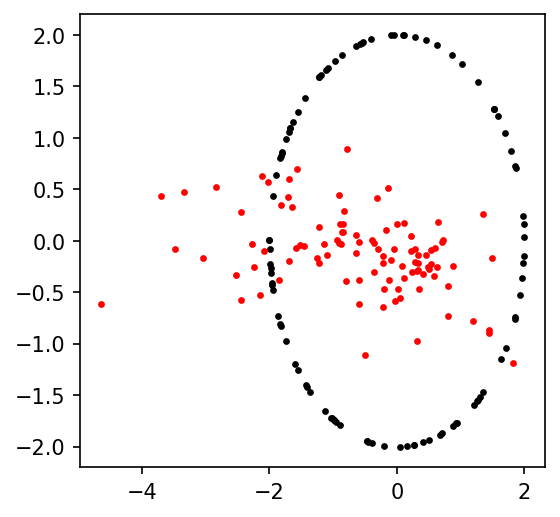

4/4 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.7500
Epoch number:  1000
Discriminator Accuracy on REAL points:  0.25999999046325684
Discriminator Accuracy on FAKE (generated) points:  0.75


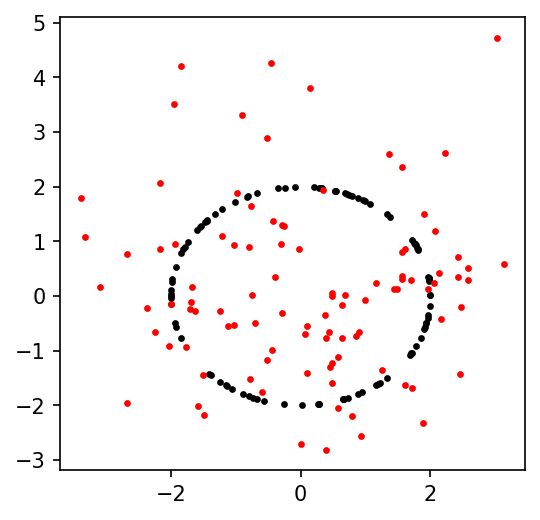

4/4 [==============================] - 0s 2ms/step - loss: 0.7651 - accuracy: 0.3700
Epoch number:  2000
Discriminator Accuracy on REAL points:  0.6899999976158142
Discriminator Accuracy on FAKE (generated) points:  0.3700000047683716


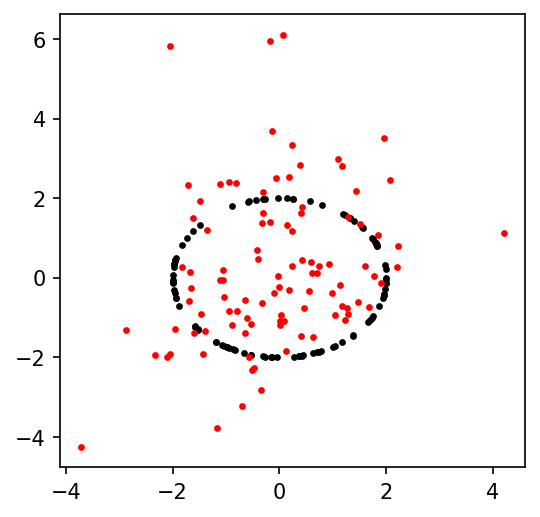

4/4 [==============================] - 0s 0s/step - loss: 0.6952 - accuracy: 0.6700
Epoch number:  3000
Discriminator Accuracy on REAL points:  0.47999998927116394
Discriminator Accuracy on FAKE (generated) points:  0.6700000166893005


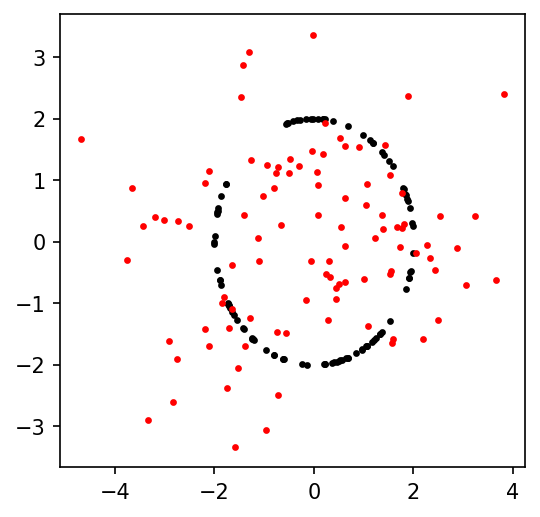

4/4 [==============================] - 0s 5ms/step - loss: 0.6382 - accuracy: 0.6900
Epoch number:  4000
Discriminator Accuracy on REAL points:  0.5
Discriminator Accuracy on FAKE (generated) points:  0.6899999976158142


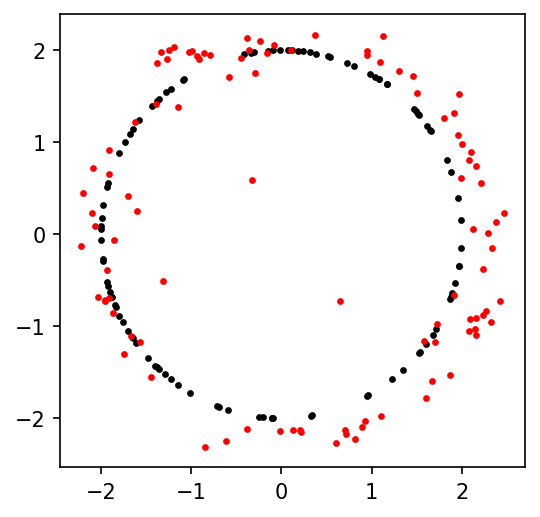

4/4 [==============================] - 0s 2ms/step - loss: 0.5548 - accuracy: 0.9300
Epoch number:  5000
Discriminator Accuracy on REAL points:  0.14000000059604645
Discriminator Accuracy on FAKE (generated) points:  0.9300000071525574


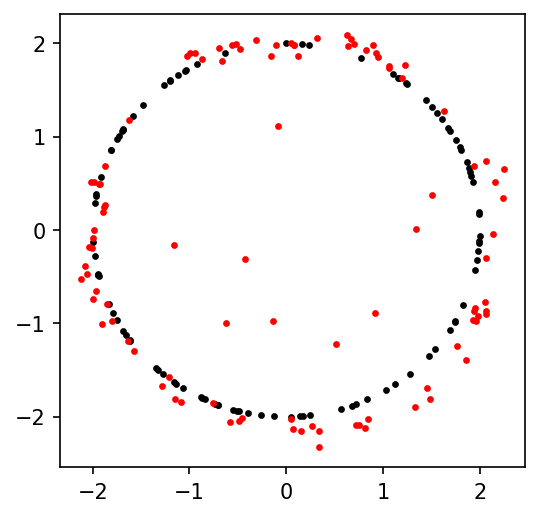

4/4 [==============================] - 0s 833us/step - loss: 0.6555 - accuracy: 0.6100
Epoch number:  6000
Discriminator Accuracy on REAL points:  0.6700000166893005
Discriminator Accuracy on FAKE (generated) points:  0.6100000143051147


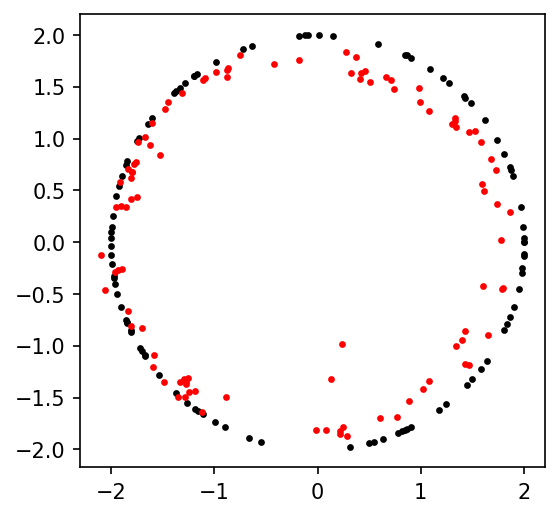

4/4 [==============================] - 0s 2ms/step - loss: 0.6764 - accuracy: 0.5200
Epoch number:  7000
Discriminator Accuracy on REAL points:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) points:  0.5199999809265137


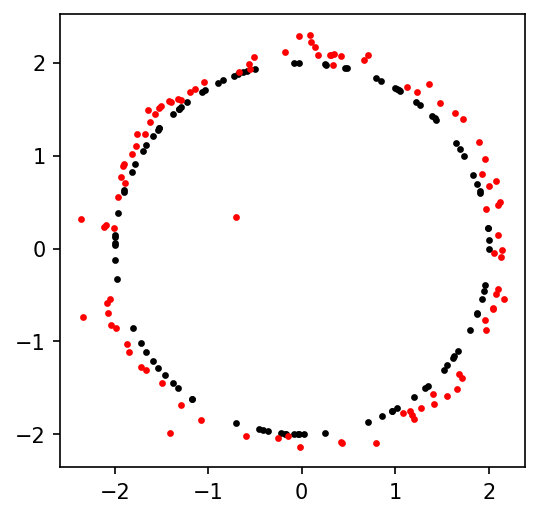

4/4 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6600
Epoch number:  8000
Discriminator Accuracy on REAL points:  0.4699999988079071
Discriminator Accuracy on FAKE (generated) points:  0.6600000262260437


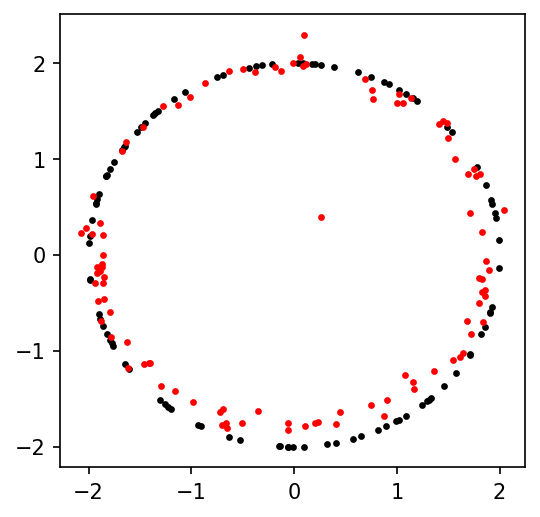

4/4 [==============================] - 0s 3ms/step - loss: 0.5621 - accuracy: 0.9100
Epoch number:  9000
Discriminator Accuracy on REAL points:  0.3199999928474426
Discriminator Accuracy on FAKE (generated) points:  0.9100000262260437


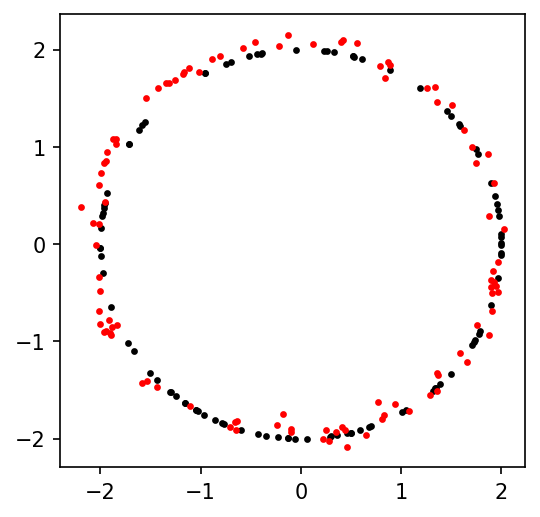

4/4 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.8000
Epoch number:  10000
Discriminator Accuracy on REAL points:  0.05999999865889549
Discriminator Accuracy on FAKE (generated) points:  0.800000011920929


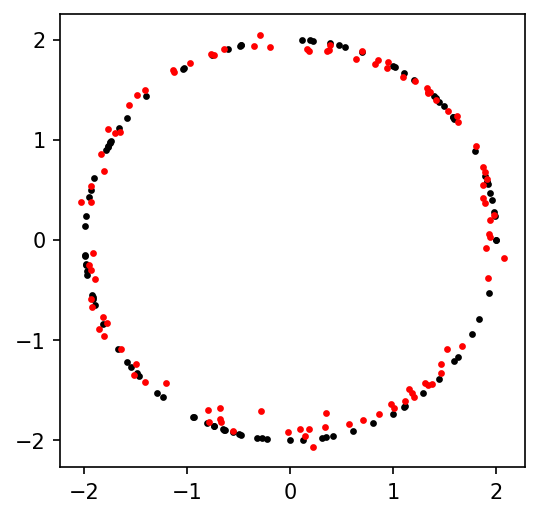

4/4 [==============================] - 0s 4ms/step - loss: 0.6622 - accuracy: 0.6500
Epoch number:  11000
Discriminator Accuracy on REAL points:  0.6899999976158142
Discriminator Accuracy on FAKE (generated) points:  0.6499999761581421


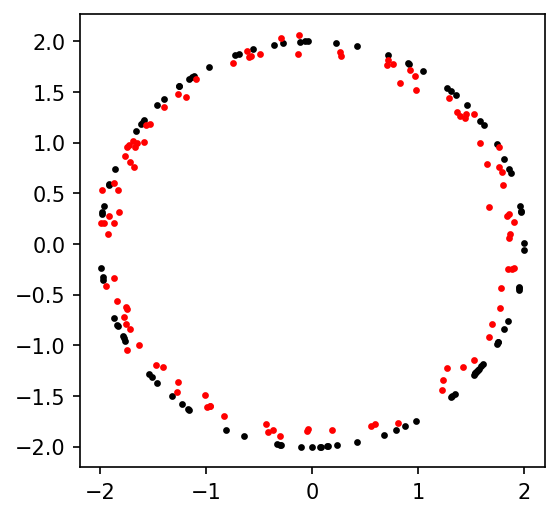

4/4 [==============================] - 0s 2ms/step - loss: 0.6174 - accuracy: 0.7200
Epoch number:  12000
Discriminator Accuracy on REAL points:  0.3100000023841858
Discriminator Accuracy on FAKE (generated) points:  0.7200000286102295


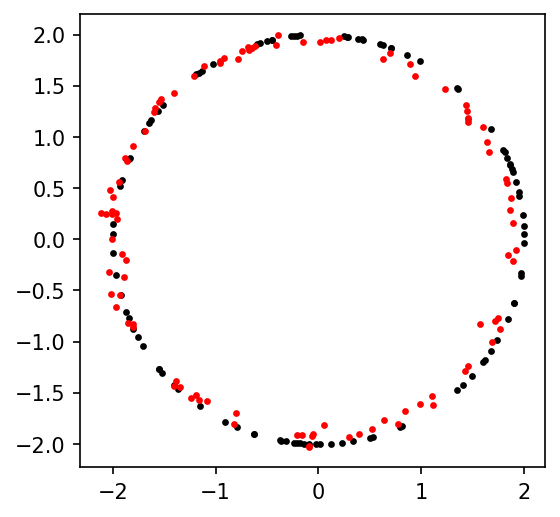

4/4 [==============================] - 0s 2ms/step - loss: 0.6118 - accuracy: 0.7200
Epoch number:  13000
Discriminator Accuracy on REAL points:  1.0
Discriminator Accuracy on FAKE (generated) points:  0.7200000286102295


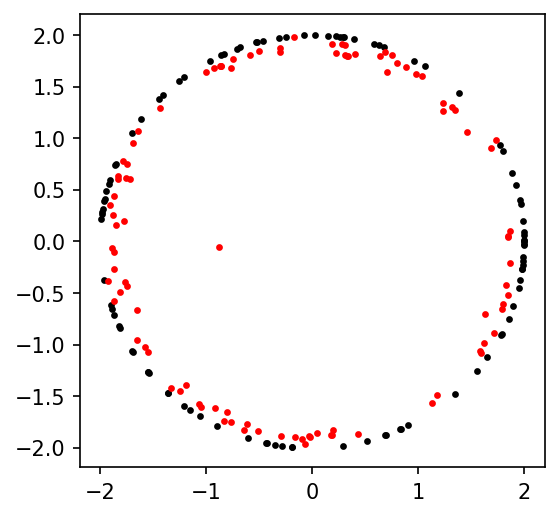

4/4 [==============================] - 0s 2ms/step - loss: 0.7857 - accuracy: 0.2600
Epoch number:  14000
Discriminator Accuracy on REAL points:  1.0
Discriminator Accuracy on FAKE (generated) points:  0.25999999046325684


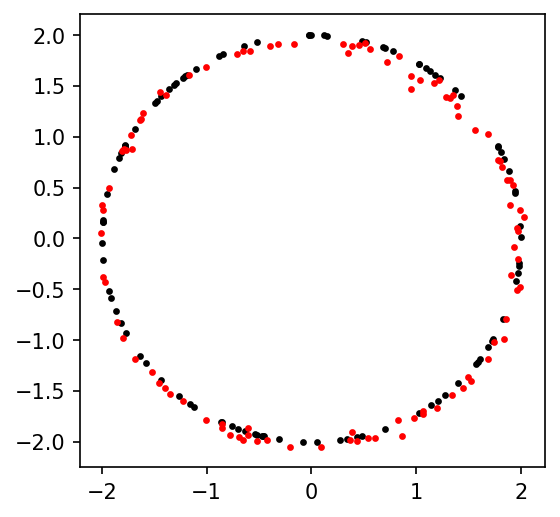

In [41]:
# Train GAN model
train(gen_model, dis_model, gan_model, latent_dim)

# As the generator improves with training, the discriminator performance gets worse because the discriminator can't easily tell the difference between real and fake. If the generator succeeds perfectly, then the discriminator has a 50% accuracy. Because as the generative image get closer to the real one the discriminator cannot distinguish whether it is fake or real because as we train the generator images are improved and getting closer to the real ones. 

# The below Epoc evaluation gives the most approximate accuracies of a random choice where the generator cannot differentiate between real and fake points: 

Epoch number:  8000
Discriminator Accuracy on REAL points:  0.4699999988079071
Discriminator Accuracy on FAKE (generated) points:  0.6600000262260437

# We did not get the perfect Accuracy of 0.5 on real and fake points. But check the red points how they get closer to the black ones creating a circle shape much better through each epoch

# This code will train our generative model. It will also show, every n_eval steps, the progress of the generative model by plotting the real and fake data (again, by fake we mean “generated by our model”).

In [43]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras import Input
from keras.layers import Dense,LSTM
from matplotlib import pyplot
import matplotlib.pyplot as plt 

In [44]:
LENGTH_INPUT = 300

In [45]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=LENGTH_INPUT):
    model = Sequential()
    model.add(Input(shape=(latent_dim, 1)))
    model.add(LSTM(150))# LSTM stands for long short-term memory networks, used in the field of Deep Learning.
    model.add(Dense(LENGTH_INPUT, activation='linear'))#since this is a continuos data we use linear activation. 
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    return model

In [46]:
# define the standalone discriminator model
def define_discriminator(n_inputs=LENGTH_INPUT):
    model = Sequential()
    model.add(Dense(LENGTH_INPUT, activation='relu', input_dim=n_inputs))
    model.add(Dense(250, activation='relu', input_dim=n_inputs))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])#whether is fake of real data. 
    return model

In [47]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [48]:
# generate n real samples with class labels
def generate_real_samples(n):
    amps = np.arange(0.1,10,0.1)
    bias = np.arange(0.1,10,0.1)
    freqs = np.linspace(1,2,1000)
    X2 = np.linspace(-5,5,LENGTH_INPUT)
    X1 = []
    for x in range(n):
        noise = np.random.normal(size=len(X2))
        X1.append(np.random.choice(amps)*np.sin(X2*np.random.choice(freqs))+np.random.choice(bias)+0.3*noise)
    X1 = np.array(X1).reshape(n, LENGTH_INPUT)
    # generate class labels. Real data is class 1. 
    y = ones((n, 1))
    return X1, y

In [49]:
X1, y = generate_real_samples(64)

In [50]:
X1.shape

(64, 300)

In [53]:
#ones for real values, 
y[0:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [54]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [55]:
x_input = generate_latent_points(3, 64)

In [57]:
x_input.shape

(64, 3)

In [58]:
# size of the latent space
latent_dim = 3
# create the generator
generator = define_generator(latent_dim)

In [59]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input, verbose=0)
    # create class labels
    y = zeros((n, 1))
    #print(x_input)
    return X, y

In [60]:
x_fake, y_fake = generate_fake_samples(generator, latent_dim, 60)

In [61]:
x_fake.shape

(60, 300)

In [62]:
#0 labels for fake values. 
y_fake[0:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [63]:
x_real, y_real = generate_real_samples(60)

In [64]:
x_real

array([[ 6.89245491,  7.19803538,  5.75814218, ...,  6.50860899,
         6.8535637 ,  6.14646715],
       [ 1.00555704,  1.09090814,  0.99032068, ...,  1.80972921,
         2.08272845,  2.45304925],
       [ 1.88370541,  2.12011127,  1.67056579, ...,  9.39761289,
         8.7824201 ,  8.72956166],
       ...,
       [ 8.66143718,  9.4107622 ,  8.82530006, ...,  6.97505814,
         6.20971155,  6.21297618],
       [-2.05735311, -2.09874569, -2.09167636, ..., 10.75457212,
        11.2542493 , 10.93762754],
       [ 3.17294213,  3.17633903,  2.91032215, ...,  0.35618348,
         0.83658536,  0.76208439]])

In [65]:
print(x_real.shape)
print(x_fake.shape)

(60, 300)
(60, 300)


In [66]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=15000, n_batch=128, n_eval=1000):
    
    # Our batch to train the discriminator will consist of half real points and half fake (generated) points
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = generate_real_samples(half_batch)
        # Prep fake (generated) samples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
    
    # Generator training
        # Get points from the latent space to be used as inputs for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i +1) % n_eval == 0:
            plt.title('Number of epochs = %i' % (i +1))
            pred_data = generate_fake_samples(generator,latent_dim,latent_dim)[0]
            real_data = generate_real_samples(latent_dim)[0]
            plt.plot(pred_data[0],'-',label='Random Fake Sample',color = 'firebrick')
            plt.plot(real_data[0],'-',label='Random Real Sample',color = 'navy')
            plt.legend(fontsize=10)
            plt.show()

In [67]:
#size of the latent space:
latent_dim = 3
#create the discriminator:
discriminator = define_discriminator()
#create generator:
generator = define_generator(latent_dim)
#create the gan:
gan_model = define_gan(generator,discriminator)

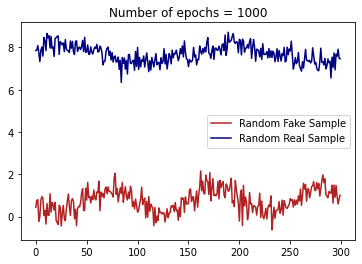

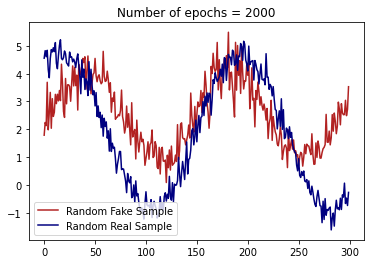

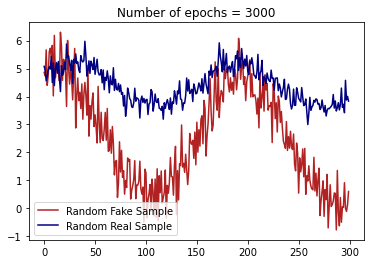

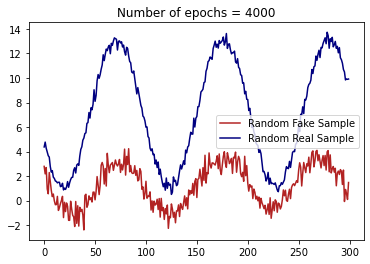

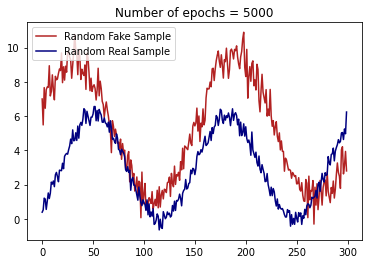

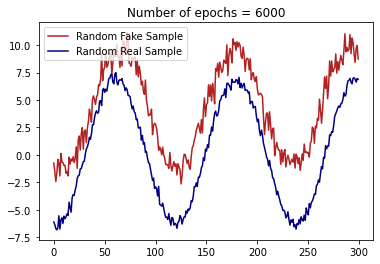

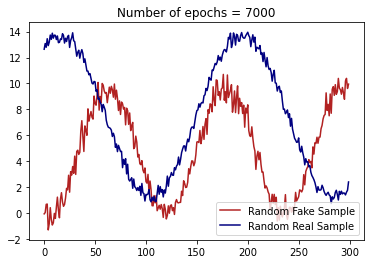

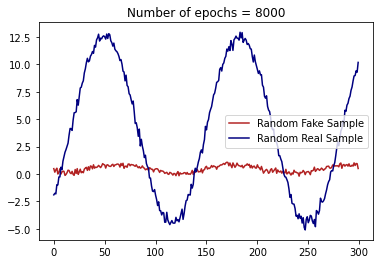

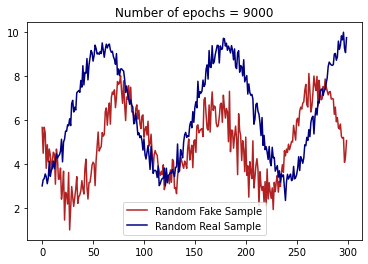

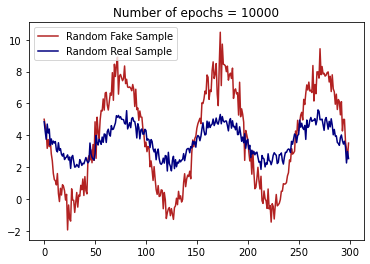

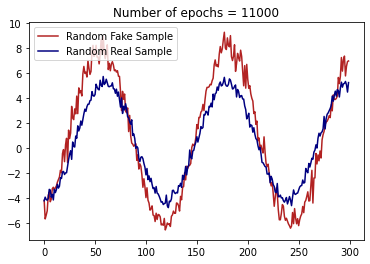

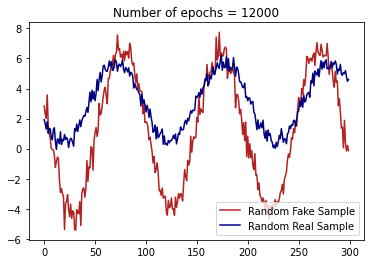

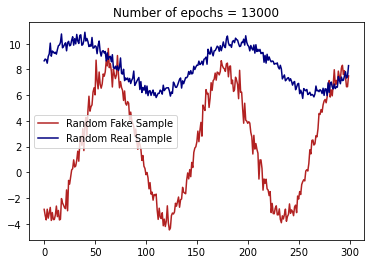

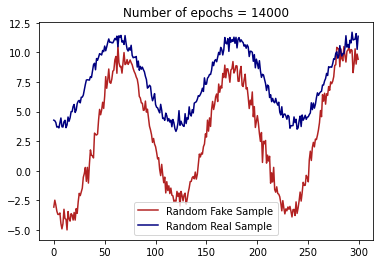

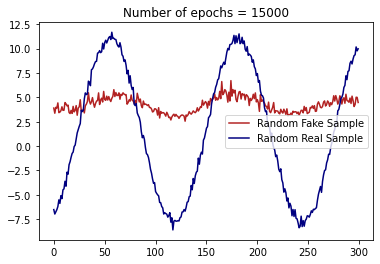

In [68]:
train(generator, discriminator, gan_model, latent_dim)

# The best epoch, 11000, gives the best results having the real and fake curves really similar.

Specifically, the generator model will learn how to generate new plausible handwritten digits between 0 and 9, using a discriminator that will try to distinguish between real images from the MNIST training dataset and new images output by the generator model.

How to Define and Train the Discriminator Model
The first step is to define the discriminator model.

The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake.

This is a binary classification problem:

Inputs: Image with one channel and 28×28 pixels in size.
Outputs: Binary classification, likelihood the sample is real (or fake).

Generator’s objective will be to generate data that is very similar to the training data. Data generated from Generator should be indistinguishable from the real data.

Discriminator takes two sets of input, one input comes from the training dataset(real data) and the other input is the dataset generated by Generator.

GAN will use the MNIST data and identify the latent feature representation for generating digits. At the end we will see how the Generators are able to generate real-looking MNIST digits.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

Loading the data from mnist dataset. we create a function load_data() function

In [43]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    #normalization between 0 and 1. 127.5 the maximum number of pixels. 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [45]:
x_train, y_train, x_test, y_test = load_data()

In [47]:
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [48]:
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [51]:
#60000 imagres with 786 pixels each. 
x_train[0].shape

(784,)

In [50]:
y_train[0]

5

In [52]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [53]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    #the ouput neurons are the same as the input_dim of the discriminator neuron. 
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 784)              

C:\Users\Admin\anacondalastone\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#generator.add(Dense(units=256,input_dim=100))
the first input layer has 256 neurons with 100 inputs. 256*100 + 256 biases = 25856
# generator.add(Dense(units=784, activation='tanh'))
the output layer has 1024 input neurons * 784 output neurons + 784 biases, one per neuron,  = 803600. 

binary_crossentropy: Used as a loss function for binary classification model. The binary_crossentropy function computes the cross-entropy loss between true labels and predicted labels. categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

In [55]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    #whether it is fake or real. 
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)              

#discriminator.add(Dense(units=1024,input_dim=784))
input layer. 1024*784 + 1024 biases = 803840
#output layer.  dense_14 (Dense)
256*1 (neuron) + 1 biases = 257. 

We now create the GAN where we combine the Generator and Discriminator. When we train the generator we will freeze the Discriminator.

We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [56]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_3 (Sequential)   (None, 784)               1486352   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


We save the generated images to file that we can view later

In [57]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [59]:
batch_size=128
batch_count = x_train.shape[0] / batch_size

In [60]:
batch_count

468.75

In [62]:
noise= np.random.normal(0,1, [batch_size, 100])
noise

array([[-0.36732441,  1.20748723, -0.48244897, ...,  0.23364285,
         0.2757158 , -0.79254743],
       [-0.6330103 ,  0.37789981, -0.41334783, ..., -0.03090899,
        -0.66208114,  1.62190161],
       [-0.40042007,  0.42467875,  0.65057787, ...,  0.16248348,
         0.6910741 , -0.88545956],
       ...,
       [ 0.74310079, -1.54862018,  0.4249975 , ..., -1.14980363,
         0.07867043, -0.23489299],
       [ 0.56877546,  0.83232824,  0.88513743, ..., -0.25369688,
        -1.69381804, -0.81997305],
       [ 2.06761949,  0.91568919, -0.61845487, ...,  1.76494695,
         0.85503428,  1.69490654]])

In [64]:
noise.shape

(128, 100)

In [66]:
generator= create_generator()

In [67]:
# Generate fake MNIST images from noised input
generated_images = generator.predict(noise)

In [68]:
generated_images

array([[-0.03326229,  0.45056352, -0.187719  , ..., -0.21568397,
        -0.11798151, -0.20861246],
       [-0.149816  ,  0.13684335, -0.01926687, ...,  0.297074  ,
         0.10710745, -0.11439595],
       [ 0.00349325,  0.3421425 ,  0.06748262, ...,  0.22788407,
         0.04566529,  0.0481347 ],
       ...,
       [-0.14795768,  0.5101803 ,  0.1807017 , ...,  0.14895852,
         0.32683313,  0.01660803],
       [ 0.00078778,  0.31566125,  0.1339757 , ...,  0.35606024,
        -0.0854294 , -0.12006278],
       [-0.18012875,  0.3548474 , -0.09152083, ...,  0.16138275,
        -0.10288541,  0.2995367 ]], dtype=float32)

In [70]:
#128 features with 784 features. 
generated_images.shape

(128, 784)

In [74]:
# Get a random set of  real images
image_batch = x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]

In [76]:
image_batch.shape

(128, 784)

In [77]:
  #Construct different batches of  real and fake data 
X= np.concatenate([image_batch, generated_images])

In [78]:
#128*2=256. 
X.shape

(256, 784)

In [87]:
x_train.shape[0]

60000

In [90]:
y_dis=np.zeros(2*batch_size)

In [92]:
y_dis.shape

(256,)

In [95]:
y_dis[:batch_size]=1

In [97]:
## Labels for generated and real data
y_dis

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [98]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.84it/s]


Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:11<00:00, 10.72it/s]


Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.35it/s]


Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.73it/s]


Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.66it/s]


Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.55it/s]


Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.90it/s]


Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.05it/s]


Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.90it/s]


Epoch 11


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.51it/s]


Epoch 12


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.31it/s]


Epoch 13


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.65it/s]


Epoch 14


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.13it/s]


Epoch 15


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:11<00:00, 10.70it/s]


Epoch 16


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:11<00:00, 10.78it/s]


Epoch 17


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.02it/s]


Epoch 18


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.88it/s]


Epoch 19


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.96it/s]


Epoch 20


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.54it/s]


Epoch 21


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.45it/s]


Epoch 22


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.28it/s]


Epoch 23


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.95it/s]


Epoch 24


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.85it/s]


Epoch 25


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.52it/s]


Epoch 26


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.78it/s]


Epoch 27


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.42it/s]


Epoch 28


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.54it/s]


Epoch 29


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.05it/s]


Epoch 30


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.59it/s]


Epoch 31


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.40it/s]


Epoch 32


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.57it/s]


Epoch 33


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.35it/s]


Epoch 34


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.04it/s]


Epoch 35


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.46it/s]


Epoch 36


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.28it/s]


Epoch 37


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.75it/s]


Epoch 38


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.12it/s]


Epoch 39


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.40it/s]


Epoch 40


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.94it/s]


Epoch 41


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.00it/s]


Epoch 42


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.64it/s]


Epoch 43


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.47it/s]


Epoch 44


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.89it/s]


Epoch 45


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.15it/s]


Epoch 46


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.39it/s]


Epoch 47


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.57it/s]


Epoch 48


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.41it/s]


Epoch 49


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.89it/s]


Epoch 50


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.74it/s]


Epoch 51


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.41it/s]


Epoch 52


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.78it/s]


Epoch 53


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.37it/s]


Epoch 54


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.33it/s]


Epoch 55


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.85it/s]


Epoch 56


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.55it/s]


Epoch 57


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.45it/s]


Epoch 58


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.65it/s]


Epoch 59


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.69it/s]


Epoch 60


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.23it/s]


Epoch 61


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.91it/s]


Epoch 62


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.74it/s]


Epoch 63


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.22it/s]


Epoch 64


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.18it/s]


Epoch 65


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.04it/s]


Epoch 66


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.60it/s]


Epoch 67


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.38it/s]


Epoch 68


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.43it/s]


Epoch 69


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.62it/s]


Epoch 70


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.32it/s]


Epoch 71


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.23it/s]


Epoch 72


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.37it/s]


Epoch 73


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.36it/s]


Epoch 74


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.58it/s]


Epoch 75


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.20it/s]


Epoch 76


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.12it/s]


Epoch 77


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.83it/s]


Epoch 78


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.97it/s]


Epoch 79


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.39it/s]


Epoch 80


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.46it/s]


Epoch 81


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.67it/s]


Epoch 82


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.45it/s]


Epoch 83


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.53it/s]


Epoch 84


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.86it/s]


Epoch 85


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.63it/s]


Epoch 86


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.27it/s]


Epoch 87


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.89it/s]


Epoch 88


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.90it/s]


Epoch 89


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.51it/s]


Epoch 90


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.65it/s]


Epoch 91


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.61it/s]


Epoch 92


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.07it/s]


Epoch 93


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.45it/s]


Epoch 94


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.11it/s]


Epoch 95


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.36it/s]


Epoch 96


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.38it/s]


Epoch 97


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.01it/s]


Epoch 98


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.97it/s]


Epoch 99


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.07it/s]


Epoch 100


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.46it/s]


Epoch 101


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.71it/s]


Epoch 102


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.44it/s]


Epoch 103


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.93it/s]


Epoch 104


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.46it/s]


Epoch 105


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.76it/s]


Epoch 106


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.05it/s]


Epoch 107


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.15it/s]


Epoch 108


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.76it/s]


Epoch 109


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.12it/s]


Epoch 110


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.32it/s]


Epoch 111


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.66it/s]


Epoch 112


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.56it/s]


Epoch 113


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.22it/s]


Epoch 114


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.86it/s]


Epoch 115


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.32it/s]


Epoch 116


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.51it/s]


Epoch 117


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.01it/s]


Epoch 118


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.74it/s]


Epoch 119


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.10it/s]


Epoch 120


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.24it/s]


Epoch 121


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.88it/s]


Epoch 122


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.82it/s]


Epoch 123


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.45it/s]


Epoch 124


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.14it/s]


Epoch 125


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.48it/s]


Epoch 126


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.73it/s]


Epoch 127


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.13it/s]


Epoch 128


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.70it/s]


Epoch 129


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.22it/s]


Epoch 130


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.45it/s]


Epoch 131


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.20it/s]


Epoch 132


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch 133


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.52it/s]


Epoch 134


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.82it/s]


Epoch 135


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.55it/s]


Epoch 136


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.26it/s]


Epoch 137


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.28it/s]


Epoch 138


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.64it/s]


Epoch 139


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.99it/s]


Epoch 140


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.02it/s]


Epoch 141


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.42it/s]


Epoch 142


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.81it/s]


Epoch 143


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.56it/s]


Epoch 144


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.92it/s]


Epoch 145


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.05it/s]


Epoch 146


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.46it/s]


Epoch 147


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.56it/s]


Epoch 148


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.51it/s]


Epoch 149


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.09it/s]


Epoch 150


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.12it/s]


Epoch 151


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.91it/s]


Epoch 152


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.47it/s]


Epoch 153


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.81it/s]


Epoch 154


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.09it/s]


Epoch 155


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.08it/s]


Epoch 156


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.38it/s]


Epoch 157


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.77it/s]


Epoch 158


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.24it/s]


Epoch 159


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.27it/s]


Epoch 160


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.47it/s]


Epoch 161


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.69it/s]


Epoch 162


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.59it/s]


Epoch 163


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.52it/s]


Epoch 164


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.75it/s]


Epoch 165


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.73it/s]


Epoch 166


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.38it/s]


Epoch 167


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.00it/s]


Epoch 168


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.86it/s]


Epoch 169


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.20it/s]


Epoch 170


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.62it/s]


Epoch 171


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.51it/s]


Epoch 172


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.92it/s]


Epoch 173


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.91it/s]


Epoch 174


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.24it/s]


Epoch 175


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.88it/s]


Epoch 176


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.08it/s]


Epoch 177


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.78it/s]


Epoch 178


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.42it/s]


Epoch 179


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.75it/s]


Epoch 180


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.50it/s]


Epoch 181


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.09it/s]


Epoch 182


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.44it/s]


Epoch 183


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.30it/s]


Epoch 184


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.16it/s]


Epoch 185


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.58it/s]


Epoch 186


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.41it/s]


Epoch 187


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.13it/s]


Epoch 188


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.08it/s]


Epoch 189


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.36it/s]


Epoch 190


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:22<00:00,  5.70it/s]


Epoch 191


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.56it/s]


Epoch 192


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.57it/s]


Epoch 193


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.00it/s]


Epoch 194


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.96it/s]


Epoch 195


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.11it/s]


Epoch 196


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.18it/s]


Epoch 197


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.40it/s]


Epoch 198


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.33it/s]


Epoch 199


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.55it/s]


Epoch 200


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.07it/s]


Epoch 201


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.32it/s]


Epoch 202


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.37it/s]


Epoch 203


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.14it/s]


Epoch 204


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.52it/s]


Epoch 205


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.04it/s]


Epoch 206


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.85it/s]


Epoch 207


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.87it/s]


Epoch 208


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.30it/s]


Epoch 209


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.87it/s]


Epoch 210


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.90it/s]


Epoch 211


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.51it/s]


Epoch 212


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.59it/s]


Epoch 213


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.61it/s]


Epoch 214


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.71it/s]


Epoch 215


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.41it/s]


Epoch 216


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.30it/s]


Epoch 217


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.11it/s]


Epoch 218


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.35it/s]


Epoch 219


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.09it/s]


Epoch 220


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.58it/s]


Epoch 221


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.84it/s]


Epoch 222


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.68it/s]


Epoch 223


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.62it/s]


Epoch 224


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.27it/s]


Epoch 225


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.54it/s]


Epoch 226


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.72it/s]


Epoch 227


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.95it/s]


Epoch 228


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.89it/s]


Epoch 229


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.62it/s]


Epoch 230


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.21it/s]


Epoch 231


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.23it/s]


Epoch 232


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch 233


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.45it/s]


Epoch 234


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.05it/s]


Epoch 235


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.48it/s]


Epoch 236


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.62it/s]


Epoch 237


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.46it/s]


Epoch 238


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.30it/s]


Epoch 239


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.05it/s]


Epoch 240


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.10it/s]


Epoch 241


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.02it/s]


Epoch 242


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.29it/s]


Epoch 243


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.20it/s]


Epoch 244


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.39it/s]


Epoch 245


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.98it/s]


Epoch 246


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.16it/s]


Epoch 247


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.38it/s]


Epoch 248


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.26it/s]


Epoch 249


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.50it/s]


Epoch 250


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.46it/s]


Epoch 251


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.64it/s]


Epoch 252


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.89it/s]


Epoch 253


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.83it/s]


Epoch 254


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.94it/s]


Epoch 255


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.21it/s]


Epoch 256


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.55it/s]


Epoch 257


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.15it/s]


Epoch 258


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.92it/s]


Epoch 259


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.06it/s]


Epoch 260


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.94it/s]


Epoch 261


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.10it/s]


Epoch 262


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:22<00:00,  5.63it/s]


Epoch 263


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.10it/s]


Epoch 264


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.57it/s]


Epoch 265


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.15it/s]


Epoch 266


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.79it/s]


Epoch 267


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 268


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.80it/s]


Epoch 269


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.09it/s]


Epoch 270


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.23it/s]


Epoch 271


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.90it/s]


Epoch 272


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.48it/s]


Epoch 273


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.16it/s]


Epoch 274


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.42it/s]


Epoch 275


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.68it/s]


Epoch 276


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.57it/s]


Epoch 277


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.33it/s]


Epoch 278


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.08it/s]


Epoch 279


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.12it/s]


Epoch 280


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.06it/s]


Epoch 281


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.42it/s]


Epoch 282


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.69it/s]


Epoch 283


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.86it/s]


Epoch 284


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.34it/s]


Epoch 285


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.12it/s]


Epoch 286


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.94it/s]


Epoch 287


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.11it/s]


Epoch 288


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.79it/s]


Epoch 289


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.59it/s]


Epoch 290


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.28it/s]


Epoch 291


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.93it/s]


Epoch 292


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.50it/s]


Epoch 293


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.73it/s]


Epoch 294


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 295


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.92it/s]


Epoch 296


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.88it/s]


Epoch 297


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.51it/s]


Epoch 298


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.18it/s]


Epoch 299


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  8.96it/s]


Epoch 300


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.47it/s]


Epoch 301


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.68it/s]


Epoch 302


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.85it/s]


Epoch 303


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.92it/s]


Epoch 304


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.88it/s]


Epoch 305


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.97it/s]


Epoch 306


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.40it/s]


Epoch 307


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00,  9.91it/s]


Epoch 308


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.10it/s]


Epoch 309


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.30it/s]


Epoch 310


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.31it/s]


Epoch 311


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.65it/s]


Epoch 312


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.50it/s]


Epoch 313


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.09it/s]


Epoch 314


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.08it/s]


Epoch 315


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.25it/s]


Epoch 316


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 317


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.45it/s]


Epoch 318


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.42it/s]


Epoch 319


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.28it/s]


Epoch 320


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.46it/s]


Epoch 321


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.76it/s]


Epoch 322


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.55it/s]


Epoch 323


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.90it/s]


Epoch 324


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.98it/s]


Epoch 325


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.11it/s]


Epoch 326


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.92it/s]


Epoch 327


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.28it/s]


Epoch 328


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.28it/s]


Epoch 329


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.30it/s]


Epoch 330


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.33it/s]


Epoch 331


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.45it/s]


Epoch 332


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.54it/s]


Epoch 333


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.18it/s]


Epoch 334


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.84it/s]


Epoch 335


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.79it/s]


Epoch 336


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.71it/s]


Epoch 337


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.63it/s]


Epoch 338


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.04it/s]


Epoch 339


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.85it/s]


Epoch 340


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.64it/s]


Epoch 341


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.34it/s]


Epoch 342


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.08it/s]


Epoch 343


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.56it/s]


Epoch 344


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.53it/s]


Epoch 345


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.54it/s]


Epoch 346


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.84it/s]


Epoch 347


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.98it/s]


Epoch 348


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.76it/s]


Epoch 349


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.10it/s]


Epoch 350


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.25it/s]


Epoch 351


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.27it/s]


Epoch 352


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.26it/s]


Epoch 353


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.48it/s]


Epoch 354


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.62it/s]


Epoch 355


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.59it/s]


Epoch 356


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.69it/s]


Epoch 357


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.92it/s]


Epoch 358


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.91it/s]


Epoch 359


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.78it/s]


Epoch 360


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.80it/s]


Epoch 361


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.16it/s]


Epoch 362


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.92it/s]


Epoch 363


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.77it/s]


Epoch 364


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.73it/s]


Epoch 365


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.06it/s]


Epoch 366


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.90it/s]


Epoch 367


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.45it/s]


Epoch 368


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.45it/s]


Epoch 369


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.81it/s]


Epoch 370


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.81it/s]


Epoch 371


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.68it/s]


Epoch 372


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.84it/s]


Epoch 373


100%|████████████████████████████████████████████████████████████████████████████| 128/128 [10:54:08<00:00, 306.63s/it]


Epoch 374


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.65it/s]


Epoch 375


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.90it/s]


Epoch 376


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.19it/s]


Epoch 377


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.25it/s]


Epoch 378


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.25it/s]


Epoch 379


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.26it/s]


Epoch 380


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.95it/s]


Epoch 381


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 382


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.36it/s]


Epoch 383


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.34it/s]


Epoch 384


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.46it/s]


Epoch 385


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.68it/s]


Epoch 386


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.74it/s]


Epoch 387


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.53it/s]


Epoch 388


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.88it/s]


Epoch 389


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.89it/s]


Epoch 390


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.64it/s]


Epoch 391


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.09it/s]


Epoch 392


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.91it/s]


Epoch 393


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.20it/s]


Epoch 394


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.04it/s]


Epoch 395


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.45it/s]


Epoch 396


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.50it/s]


Epoch 397


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.67it/s]


Epoch 398


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.36it/s]


Epoch 399


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.64it/s]


Epoch 400


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.68it/s]
C:\Users\Admin\AppData\Local\Temp/ipykernel_19080/3839092293.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


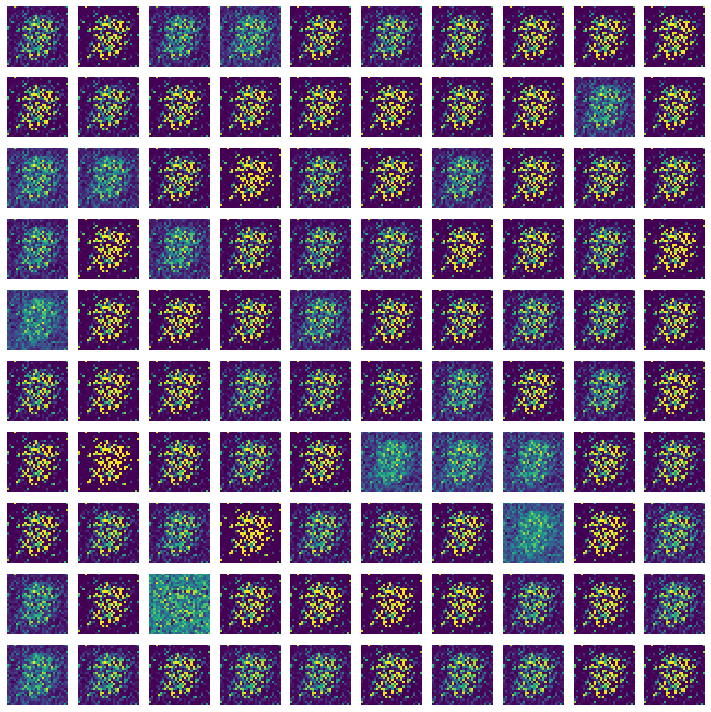

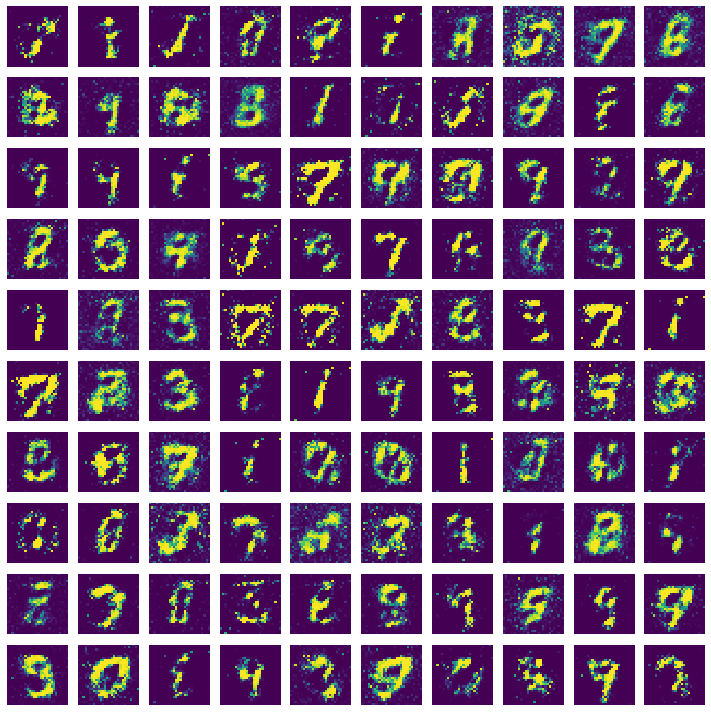

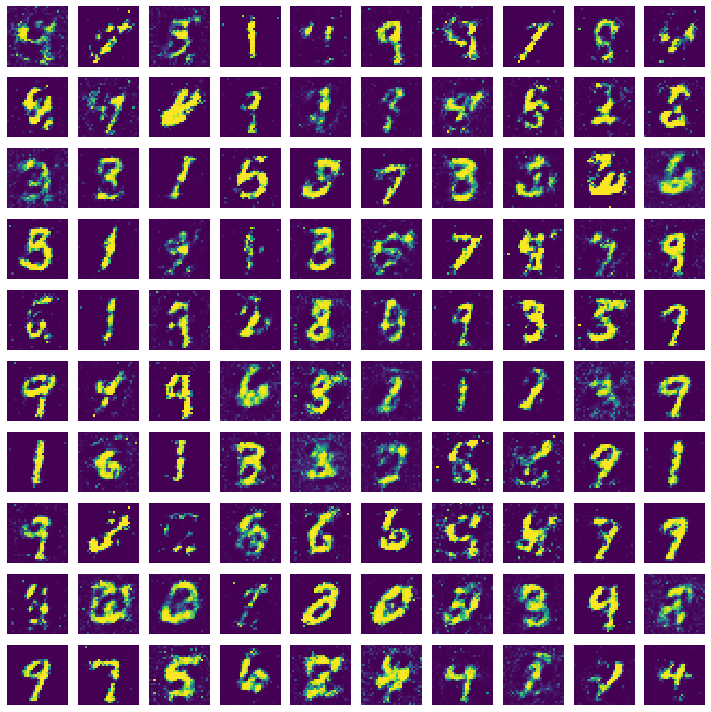

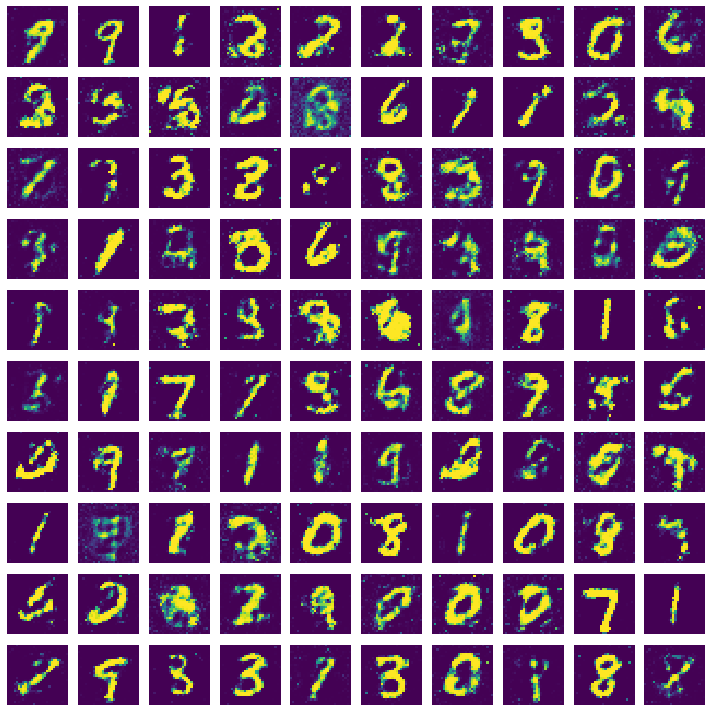

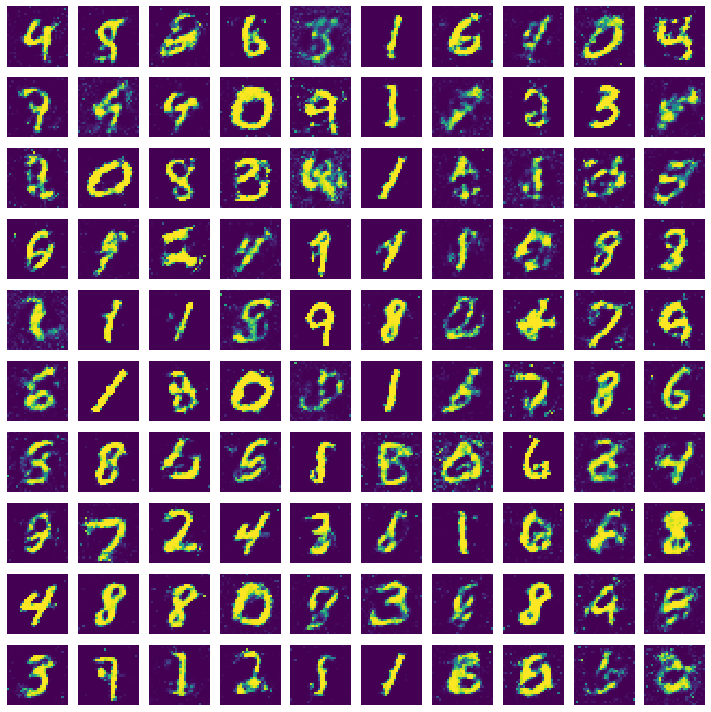

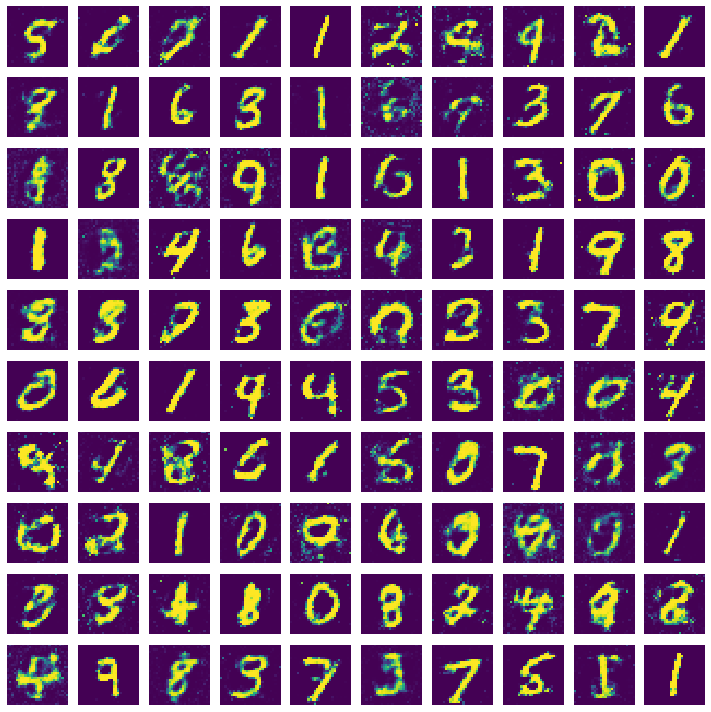

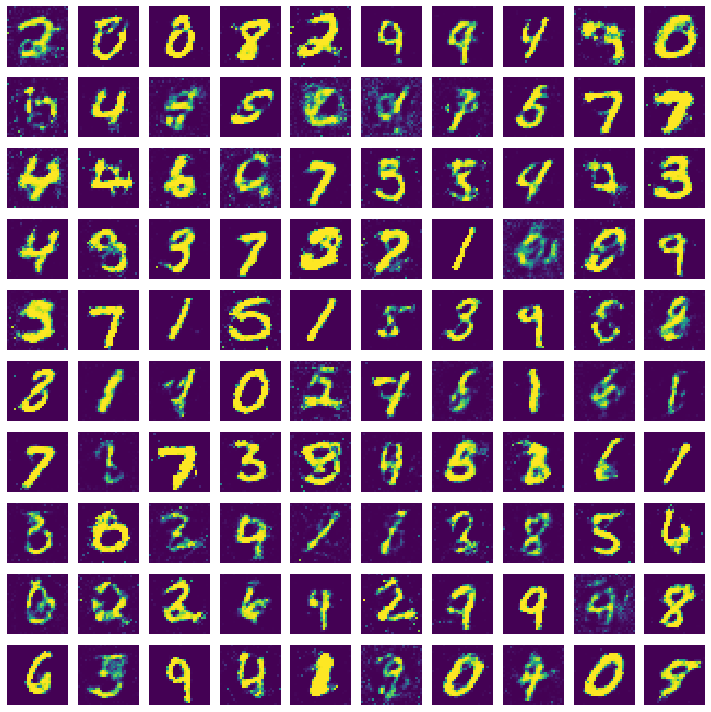

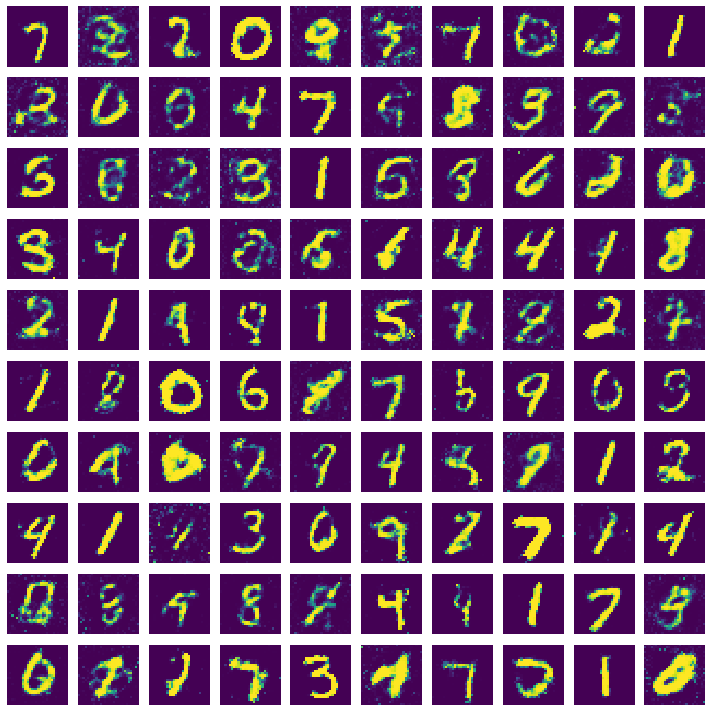

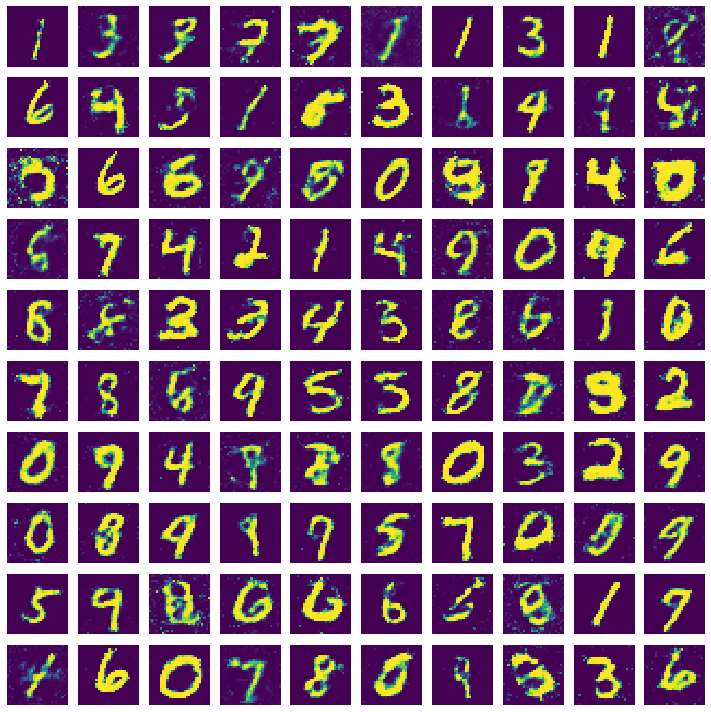

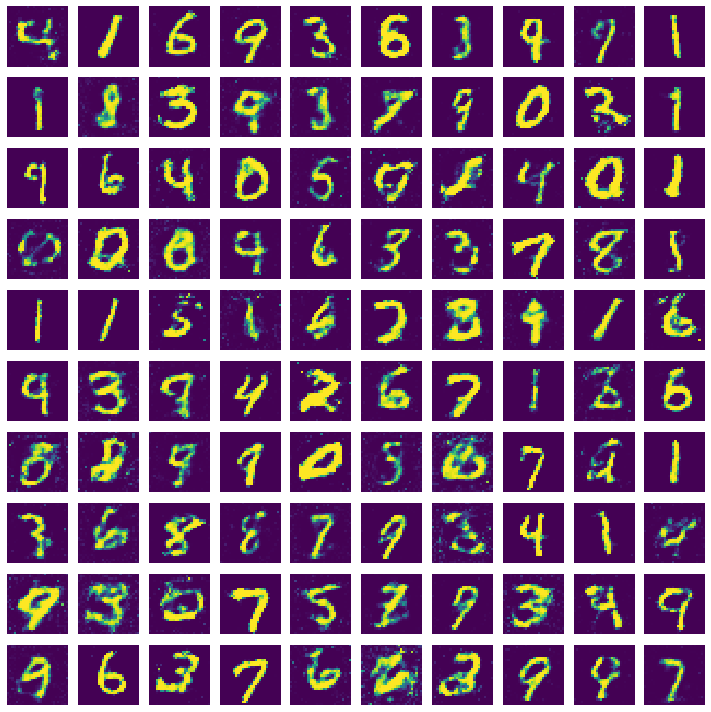

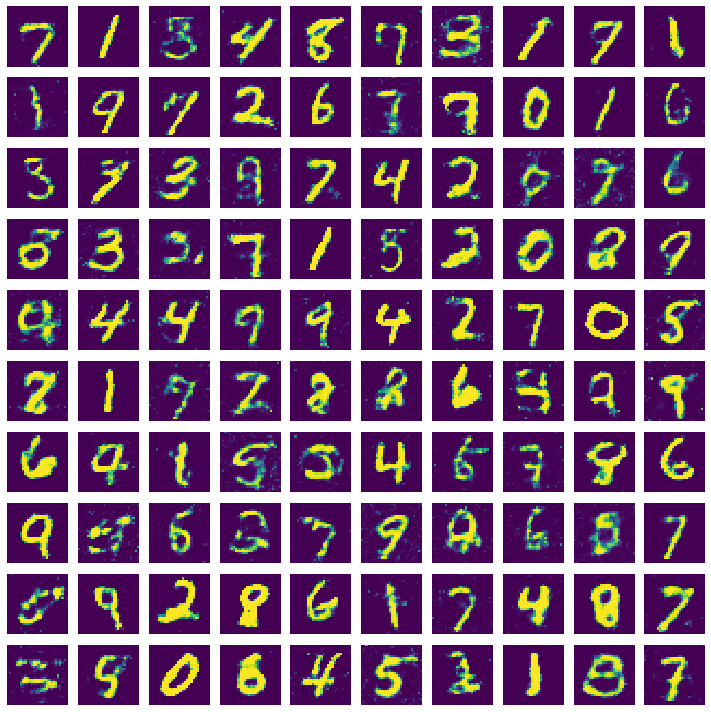

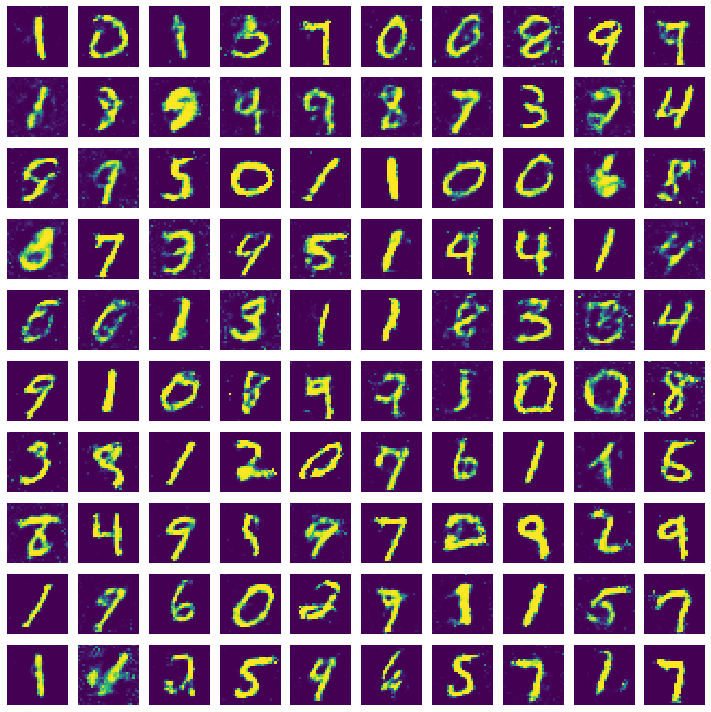

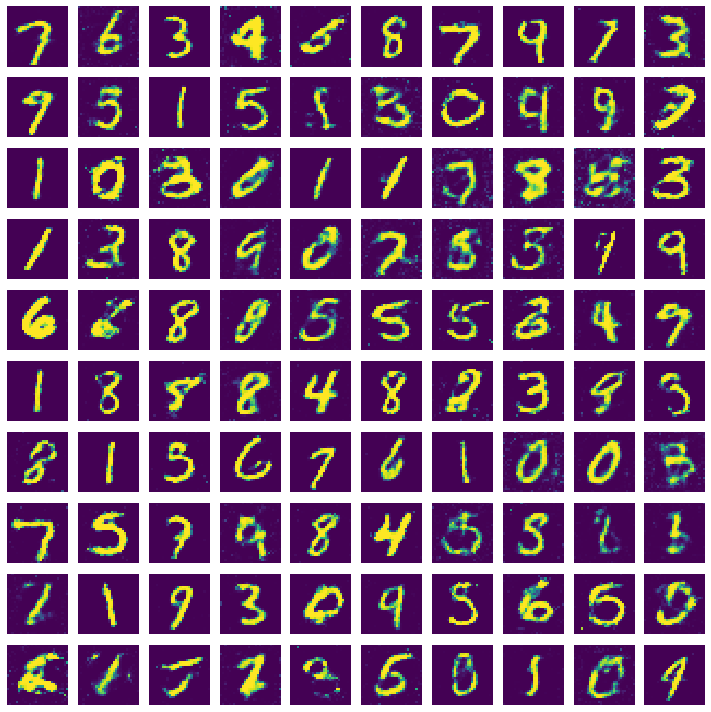

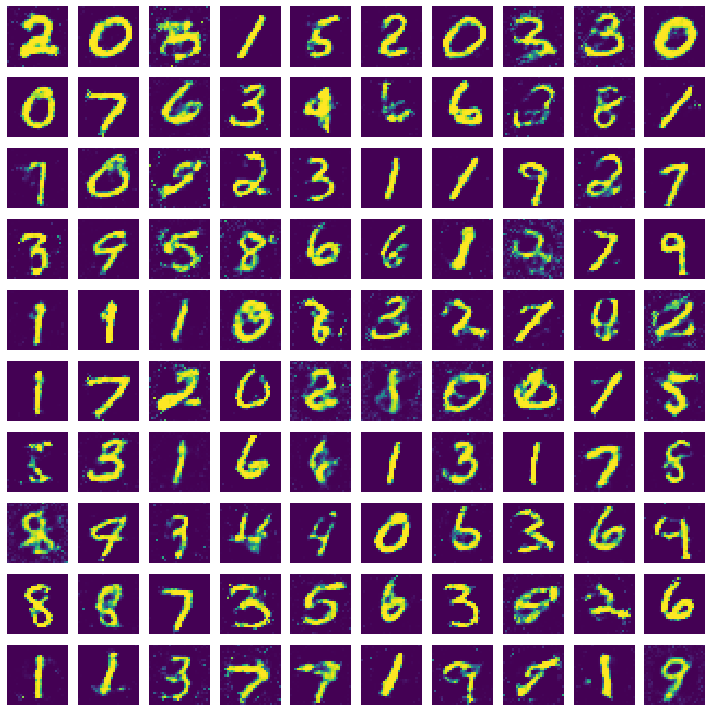

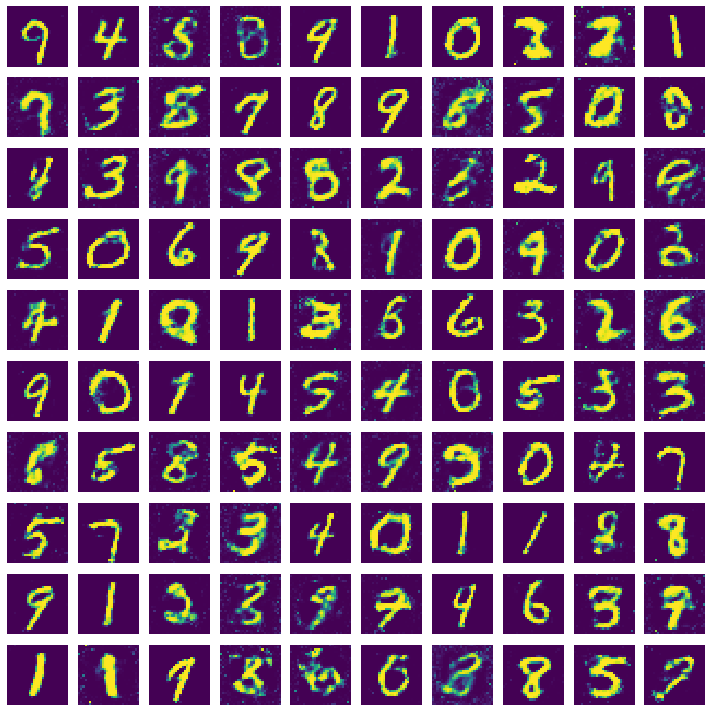

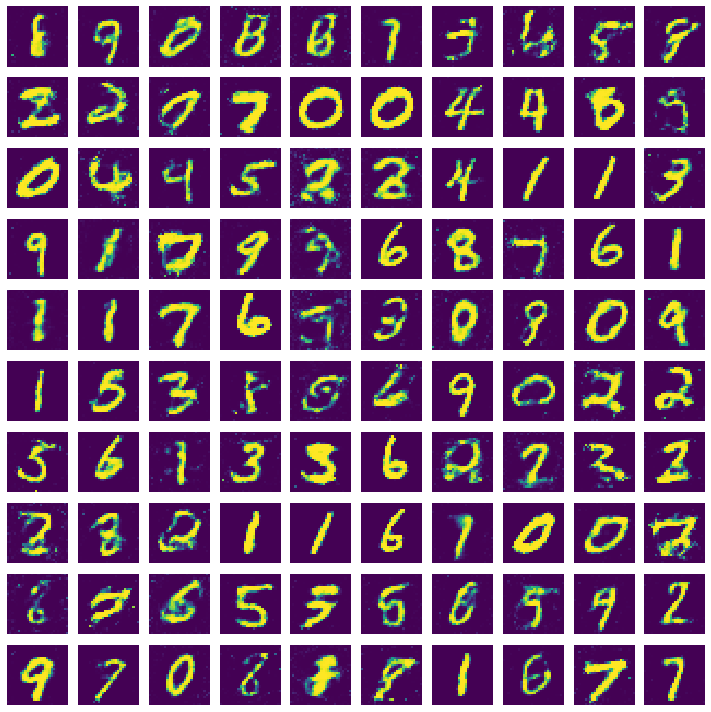

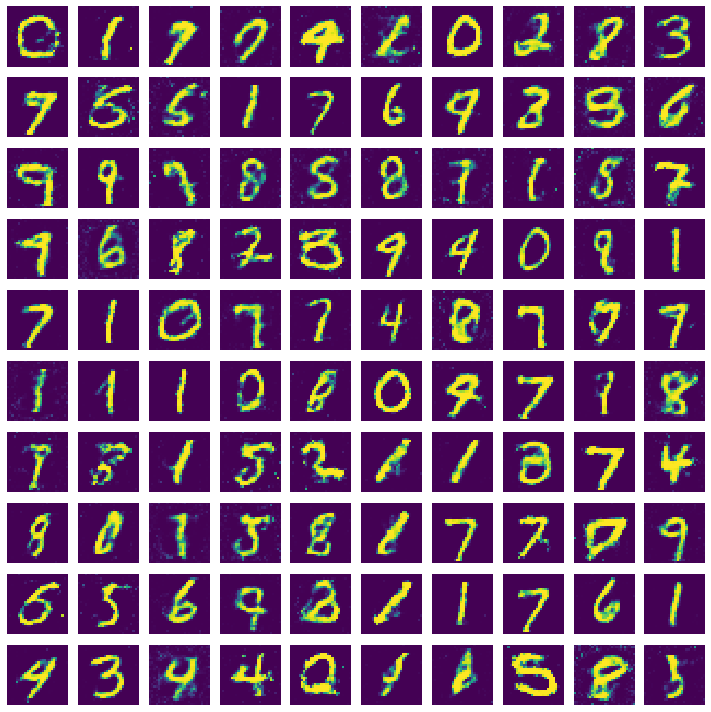

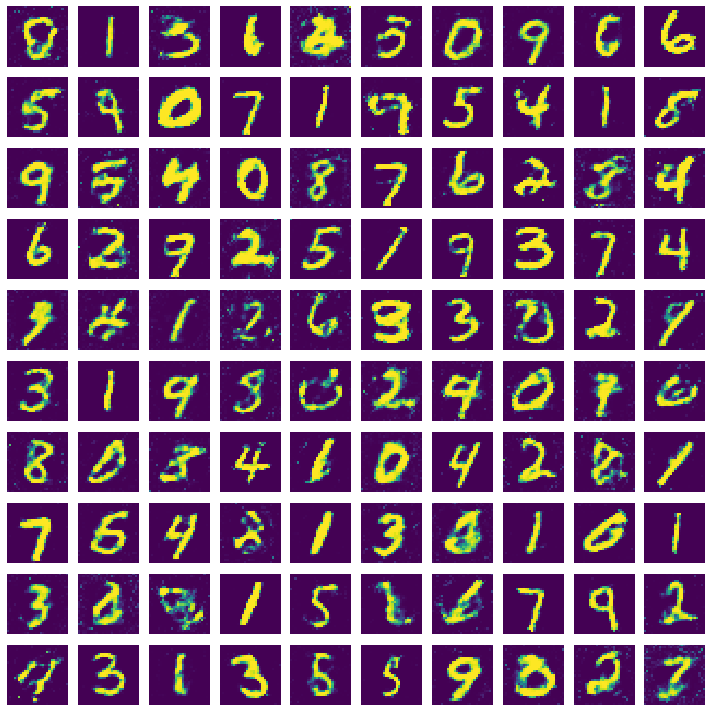

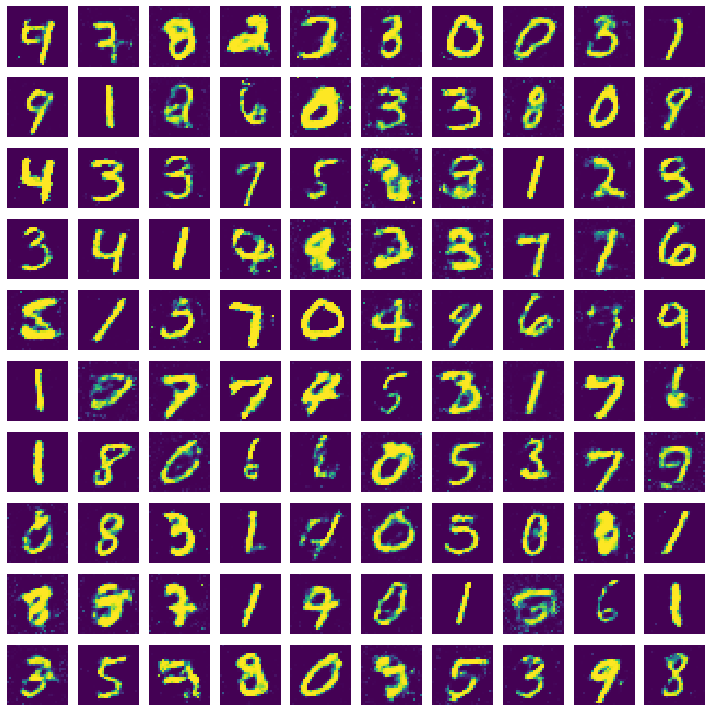

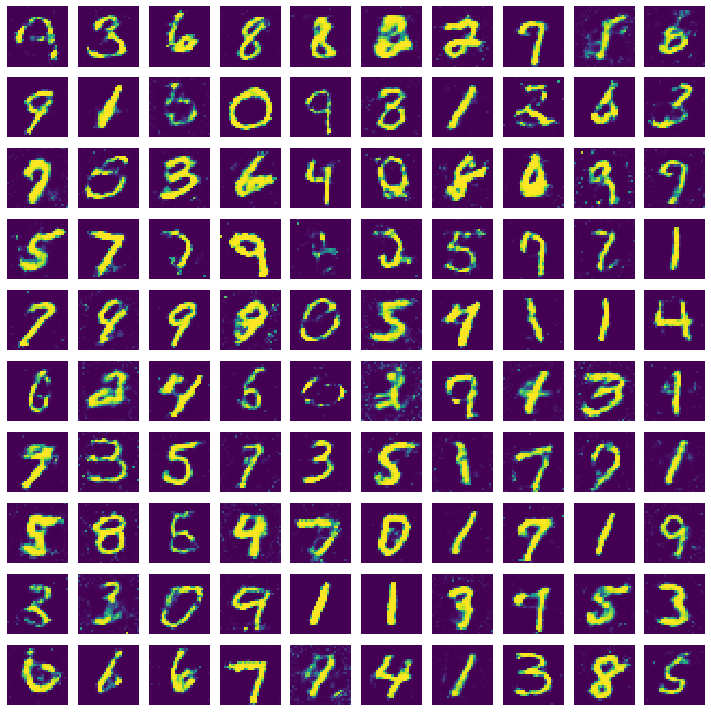

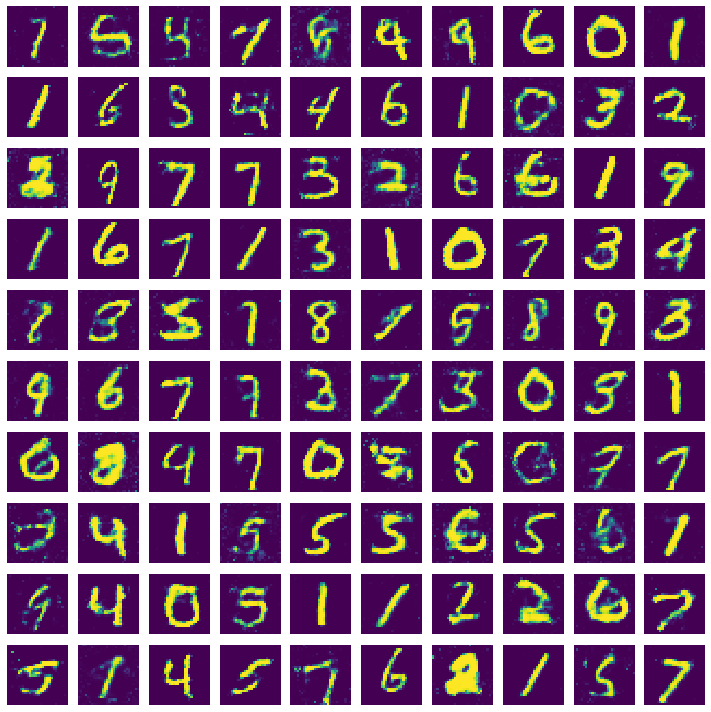

In [99]:
training(400,128)

# Thank you! 